# CNN Classifier Technical Report

## Overview
This report outlines the methodologies and results from training a CNN machine learning classifiers to detect malware using opcode sequences. The classifier is based on the white paper 'Deep Android Malware Detection' by McLaughlin et al. (2017).

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Embedding


base_path = '/Users/jeffreyjeyachandren/Desktop/opscode_ml/opcodes'  #opscode folder path



/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



## Data Preparation and Feature Engineering

### `read_opcode_files(base_path)`
- Reads opcode files organized by APT groups, processes them into comma-separated sequences, and saves the data to `opcodes_dataset.csv`.
- Returns a DataFrame with `Opcodes` and `APT` group labels.

### `preprocess_opcodes(opcode_sequences, vocab_size, max_sequence_length)`
- Converts raw opcode sequences into integer-encoded sequences based on a predefined vocabulary of opcodes.
- Pads the sequences to ensure uniform length for input into the model.
- Outputs a NumPy array suitable for model training.

### Dataset Description
- Each opcode sequence represents the operational behavior of the malware..
- Labels indicate the associated APT group
- The dataset is divided into training, validation, and testing sets with an 80-10-10 split.

### Overview
- The Convolutional Neural Network (CNN) uses **raw opcode sequences** as input.
- Quote from Mclaughlin et al. (2017): *"Features indicative of malware are automatically learned by the network from the raw opcode sequence, thus removing the need for hand-engineered malware features"* 

In [2]:
def read_opcode_files(base_path):
    data = []
    labels = []
    
    # Walk through all directories
    for apt_folder in os.listdir(base_path):
        apt_path = os.path.join(base_path, apt_folder)
        if os.path.isdir(apt_path):
            # Process each file in the APT folder
            for file_path in glob.glob(os.path.join(apt_path, '*')):
                with open(file_path, 'r') as f:
                    # Split by newline and join with commas
                    opcodes = f.read().strip()
                    opcodes = ', '.join(op.strip() for op in opcodes.split('\n') if op.strip())
                    data.append(opcodes)
                    labels.append(apt_folder)
    
    # Create the DataFrame
    df = pd.DataFrame({'Opcodes': data, 'APT': labels})
    
    # Print the first few rows of the DataFrame
    print("Preview of the DataFrame before n-gram extraction:")
    print(df.head())
    
    # Save to CSV
    output_path = 'opcodes_dataset.csv'
    df.to_csv(output_path, index=False)
    print(f"\nDataset saved to: {output_path}")
    
    return df

def extract_ngram_features(df, n=1):
    """Extract n-gram features from opcode sequences"""
    if n == 1:
        # Get all unique opcodes
        unique_ngrams = set()
        for opcodes in df['Opcodes']:
            unique_ngrams.update(op.strip() for op in opcodes.split(', '))
        
        # Sort the unique opcodes for consistent column ordering
        unique_ngrams = sorted(unique_ngrams)
        
        # Create a DataFrame with opcode frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_ngrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            counts = Counter(opcode_list)
            
            for opcode, count in counts.items():
                ngram_counts_df.at[i, opcode] = count
                
    else:
        # Get all unique n-grams from the entire dataset
        all_ngrams = set()
        for opcodes in df['Opcodes']:
            opcode_list = [op.strip() for op in opcodes.split(', ')]
            ngrams = list(zip(*[opcode_list[i:] for i in range(n)]))
            ngram_strings = [f"{'-'.join(ng)}" for ng in ngrams]
            all_ngrams.update(ngram_strings)
        
        # Sort the unique n-grams for consistent column ordering
        unique_ngrams = sorted(all_ngrams)
        
        # Create a DataFrame with n-gram frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_ngrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            ngrams = list(zip(*[opcode_list[i:] for i in range(n)]))
            ngram_strings = [f"{'-'.join(ng)}" for ng in ngrams]
            counts = Counter(ngram_strings)
            
            for ngram, count in counts.items():
                ngram_counts_df.at[i, ngram] = count
    
    return ngram_counts_df.values, ngram_counts_df.columns.tolist()

This cell performs the following steps:
1. Reads and processes opcode data from the specified folder.
2. Extracts 1-gram, 2-gram, and 3-gram features from the data.
3. Scales the extracted features using standard scaling.
4. Combines scaled features for multi-gram analysis.
5. Encodes the target labels (APT groups) for classification.
6. Splits the data into training and testing sets for each feature set.


In [3]:
# Read and process data
df = read_opcode_files(base_path)

# Extract n-gram features
X_1gram, cols_1gram = extract_ngram_features(df, n=1)
X_2gram, cols_2gram = extract_ngram_features(df, n=2)
X_3gram, cols_3gram = extract_ngram_features(df, n=3)

# Scale features
scaler = StandardScaler()
X_1gram_scaled = scaler.fit_transform(X_1gram)
X_2gram_scaled = scaler.fit_transform(X_2gram)
X_3gram_scaled = scaler.fit_transform(X_3gram)

# Create combined features
X_combined = np.concatenate([X_1gram_scaled, X_2gram_scaled, X_3gram_scaled], axis=1)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['APT'])

# Split data for each feature set
X_train_1gram, X_test_1gram, y_train_1gram, y_test_1gram = train_test_split(
    X_1gram_scaled, y, test_size=0.2, random_state=42
)
X_train_2gram, X_test_2gram, y_train_2gram, y_test_2gram = train_test_split(
    X_2gram_scaled, y, test_size=0.2, random_state=42
)
X_train_3gram, X_test_3gram, y_train_3gram, y_test_3gram = train_test_split(
    X_3gram_scaled, y, test_size=0.2, random_state=42
)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

Preview of the DataFrame before n-gram extraction:
                                             Opcodes            APT
0  JMP, JMP, JMP, JMP, JMP, JMP, JMP, JMP, POP, P...        Evilnum
1  PUSH, MOV, MOV, CALL, PUSH, PUSH, PUSH, PUSH, ...  APT19_opcodes
2  MOV, PUSH, MOV, CALL, TEST, PUSH, CALL, ADD, M...  APT19_opcodes
3  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes
4  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes

Dataset saved to: opcodes_dataset.csv


# Convolutional Neural Network (CNN) Training and Evaluation

## Define CNN Model
This section defines a function to create a CNN model for classification tasks. 
The model includes:
- Two Conv1D layers with ReLU activation and MaxPooling.
- Dropout layers to reduce overfitting.
- A Dense layer for fully connected processing.
- A final Dense layer with softmax activation for multi-class classification.
The model is compiled with:
- Adam optimizer.
- Sparse categorical cross-entropy loss.
- Accuracy as a performance metric.

## Train and Evaluate Models
This section trains CNN models for each n-gram feature set (1-gram, 2-gram, 3-gram, combined).

### Steps:
1. **Reshape Data**: Convert feature sets into shapes compatible with Conv1D layers.
2. **Create CNN Model**: Instantiate the CNN model using the defined function.
3. **Train the Model**: Train the CNN on the respective feature set.
   - Training includes:
     - 10 epochs.
     - Batch size of 32.
     - 20% of training data reserved for validation.
4. **Evaluate the Model**: 
   - Predict class probabilities and extract predicted class labels.
   - Calculate the accuracy score.
   - Generate a classification report with:
     - Unique class labels.
     - Matching target names from the label encoder.
5. **Store Results**:
   - Save accuracy, training history, true labels, and predicted labels for each feature set.

### Outputs:
- Model training progress and validation results.
- Accuracy and classification report for each feature set.




Training model with 1-gram features
Epoch 1/10


/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1946 - loss: 3.5336 - val_accuracy: 0.1429 - val_loss: 2.9650
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1591 - loss: 2.6915 - val_accuracy: 0.1429 - val_loss: 2.9909
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2278 - loss: 2.7054 - val_accuracy: 0.0571 - val_loss: 2.9884
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1758 - loss: 2.3987 - val_accuracy: 0.2571 - val_loss: 2.8238
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4119 - loss: 2.0766 - val_accuracy: 0.2857 - val_loss: 2.8856
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4672 - loss: 1.8142 - val_accuracy: 0.2857 - val_loss: 2.9133
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4603 - loss: 1.8135 - val_accuracy: 0.2857 - val_loss: 3.0781
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5330 - loss: 1.6831 - val_accuracy: 0.3143 - val_loss: 3.5269
Epoch 9/10


/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

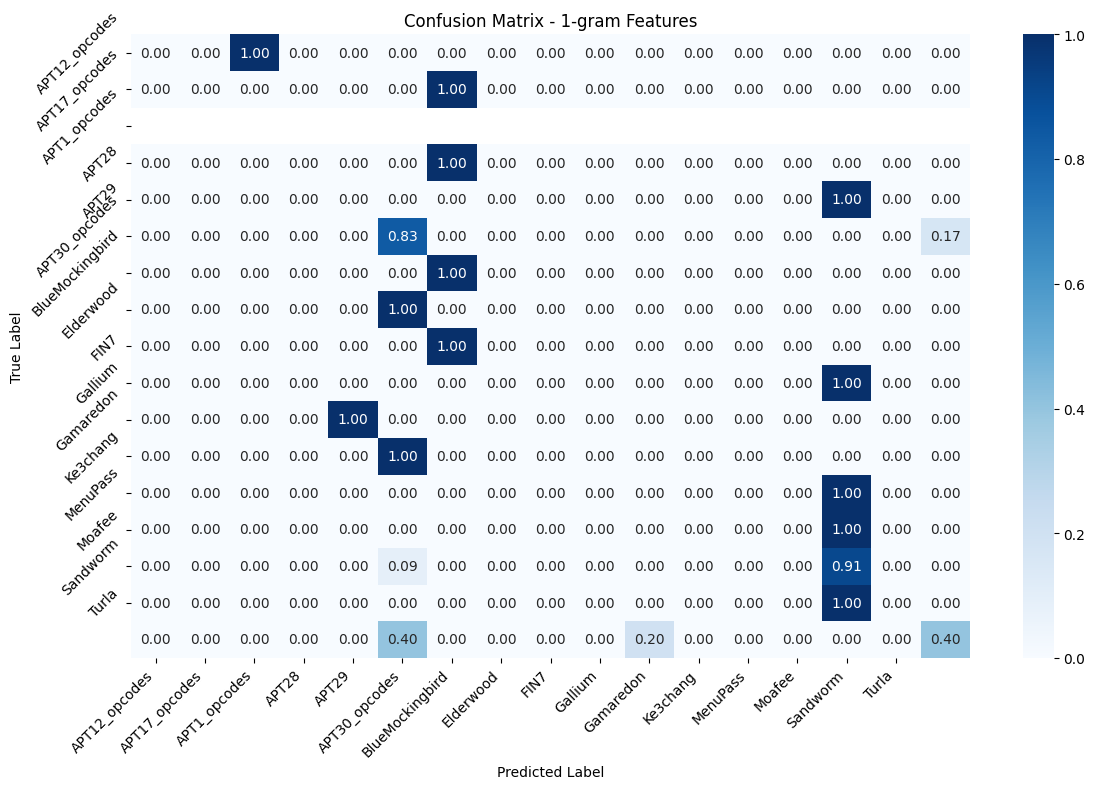


1-gram Results:
Accuracy: 0.4651

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.50      0.83      0.62         6
  APT30_opcodes       0.33      1.00      0.50         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.00      0.00      0.00         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.56      0.91      0.69        11
       Sandworm       0.00      0.00      0.00         1
          Turla       0.67   

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.1132 - loss: 8.4823 - val_accuracy: 0.1714 - val_loss: 3.3872
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2214 - loss: 3.3048 - val_accuracy: 0.1714 - val_loss: 3.2056
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.2535 - loss: 2.9737 - val_accuracy: 0.2000 - val_loss: 3.0084
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3497 - loss: 2.4683 - val_accuracy: 0.1714 - val_loss: 3.2940
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3861 - loss: 2.3223 - val_accuracy: 0.2286 - val_loss: 3.2169
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4669 - loss: 1.8086 - val_accuracy: 0.2000 - val_loss: 3.4035
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6941 - loss: 1.2241 - val_accuracy: 0.3429 - val_loss: 4.4869
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7696 - loss: 1.1560 - val_accuracy: 0.3714 - val_loss: 5.2451
Epoch 9/10


/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

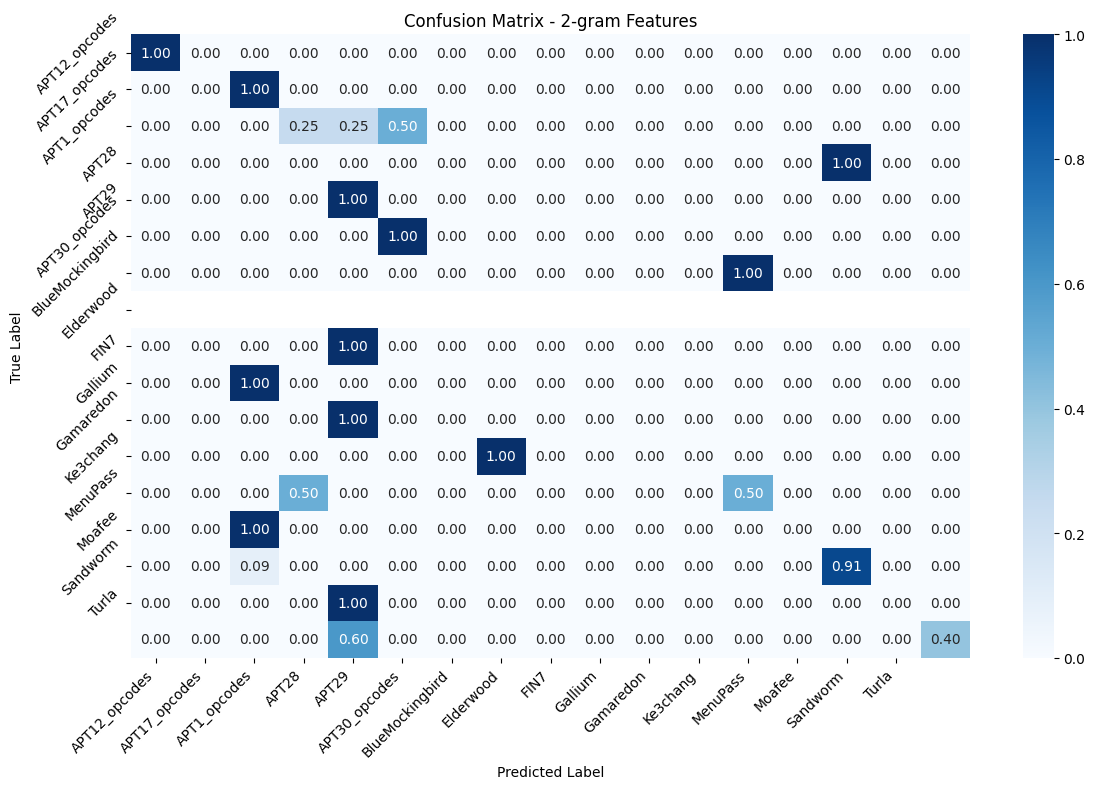


2-gram Results:
Accuracy: 0.5349

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       1.00      1.00      1.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.46      1.00      0.63         6
  APT30_opcodes       0.60      1.00      0.75         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.50      0.50      0.50         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.77      0.91      0.83        11
       Sandworm       0.00      0.00      0.00         1
          Turla       1.00   

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.1016 - loss: 61.8485 - val_accuracy: 0.0857 - val_loss: 3.4011
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.1950 - loss: 3.3284 - val_accuracy: 0.1429 - val_loss: 3.2316
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.1600 - loss: 3.0868 - val_accuracy: 0.1429 - val_loss: 2.9992
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.1387 - loss: 2.8128 - val_accuracy: 0.1429 - val_loss: 2.9085
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.2518 - loss: 2.5529 - val_accuracy: 0.1429 - val_loss: 2.9993
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.1914 - loss: 2.4894 - val_accuracy: 0.1429 - val_loss: 3.1026
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.2132 - loss: 2.6731 - val_accuracy: 0.1429 - val_loss: 3.1290
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.2185 - loss: 2.5371 - val_accuracy: 0.1429 - val_loss: 3.1422
Ep

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

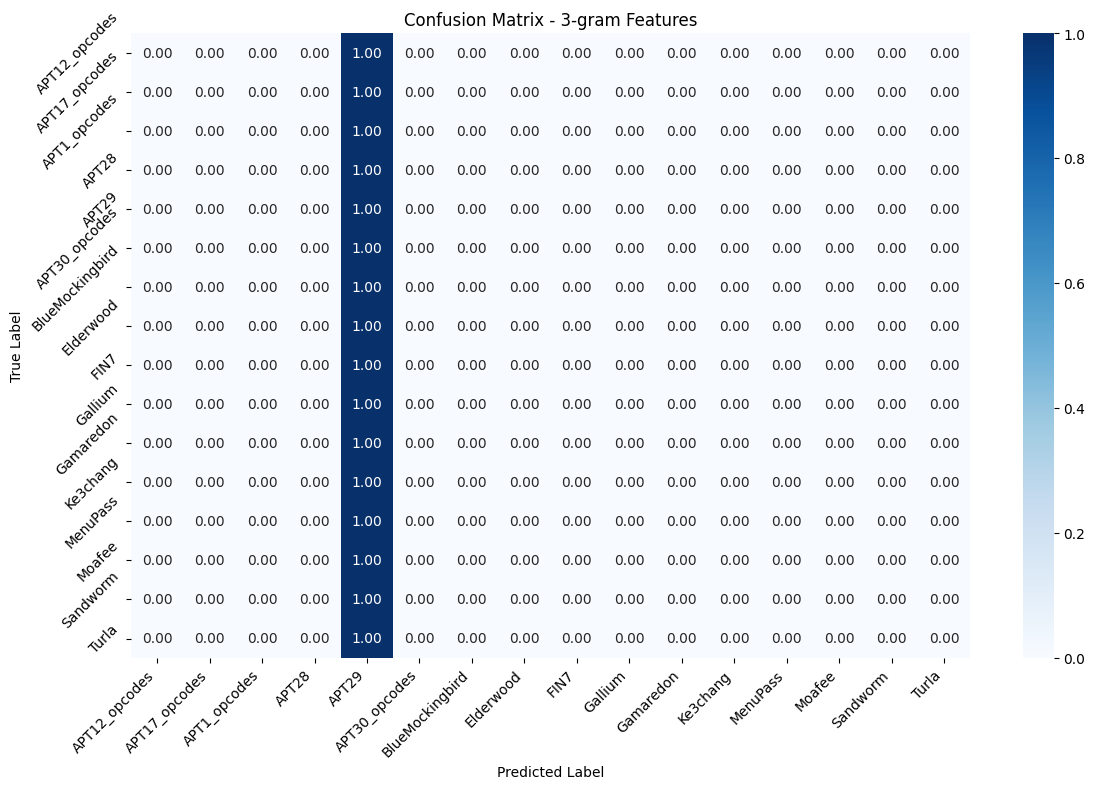


3-gram Results:
Accuracy: 0.1395

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.14      1.00      0.24         6
  APT30_opcodes       0.00      0.00      0.00         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.00      0.00      0.00         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.00      0.00      0.00        11
       Sandworm       0.00      0.00      0.00         1
          Turla       0.00   

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.0777 - loss: 24.4271 - val_accuracy: 0.1714 - val_loss: 3.4001
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.1997 - loss: 3.0021 - val_accuracy: 0.1714 - val_loss: 3.3128
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.1687 - loss: 2.5281 - val_accuracy: 0.1714 - val_loss: 3.2443
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.2266 - loss: 2.3964 - val_accuracy: 0.1714 - val_loss: 3.2033
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.2130 - loss: 2.7794 - val_accuracy: 0.1714 - val_loss: 3.1296
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.2138 - loss: 2.5797 - val_accuracy: 0.1714 - val_loss: 3.0802
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.2334 - loss: 2.4801 - val_accuracy: 0.1714 - val_loss: 3.0536
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.1686 - loss: 2.3624 - val_accuracy: 0.1714 - val_loss: 3.0500
Ep

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

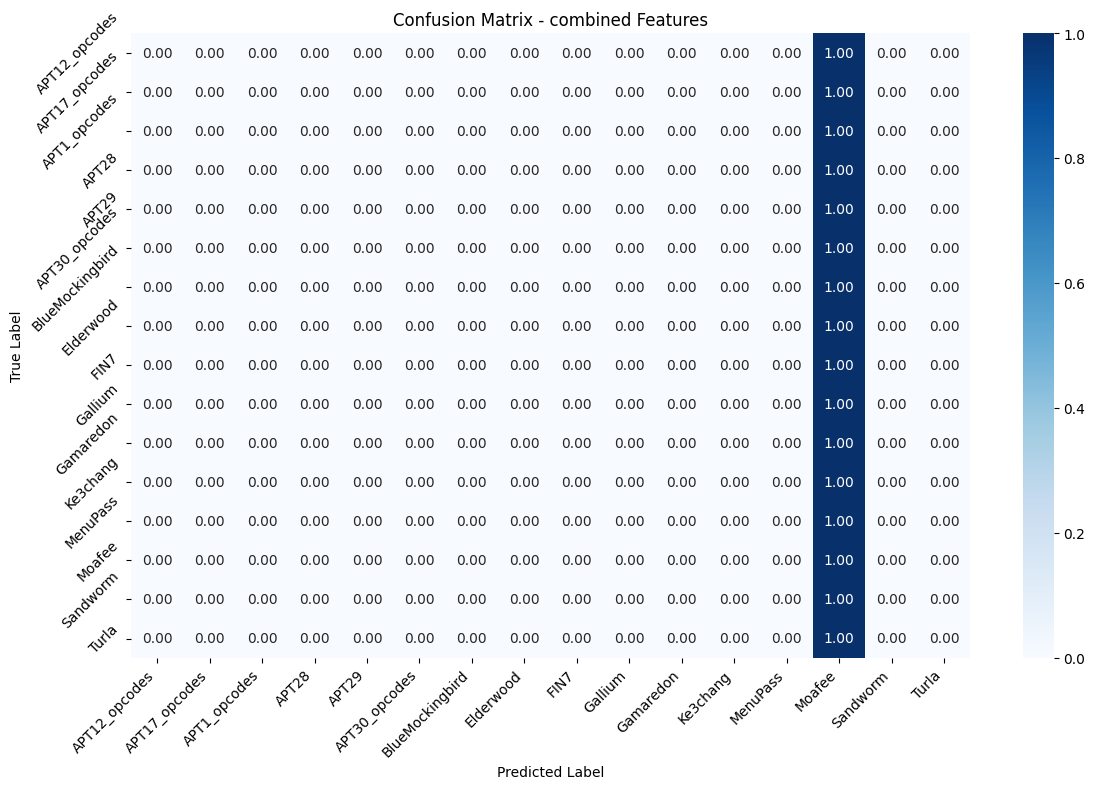


combined Results:
Accuracy: 0.2558

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.00      0.00      0.00         6
  APT30_opcodes       0.00      0.00      0.00         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.00      0.00      0.00         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.26      1.00      0.41        11
       Sandworm       0.00      0.00      0.00         1
          Turla       0.00 

In [4]:
# Define CNN model function
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_shape, 1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Create Adam optimizer with learning rate from the paper
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)  # Changed from default 1e-3 to 1e-2
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train models for each n-gram feature set, as per McLaughlin et al. (2017)
feature_sets = {
    '1-gram': (X_train_1gram, X_test_1gram, y_train_1gram, y_test_1gram),
    '2-gram': (X_train_2gram, X_test_2gram, y_train_2gram, y_test_2gram),
    '3-gram': (X_train_3gram, X_test_3gram, y_train_3gram, y_test_3gram),
    'combined': (X_train_combined, X_test_combined, y_train_combined, y_test_combined)
}

results = {}
for name, (X_train, X_test, y_train, y_test) in feature_sets.items():
    print(f"\nTraining model with {name} features")
    
    # Reshape data for CNN
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Create and train model with parameters from McLaughlin et al. (2017)
    model = create_cnn_model(X_train.shape[1], len(np.unique(y)))
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=10,
        batch_size=16,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    
    # Get the actual classes present in the test set
    unique_classes = np.unique(y_test)
    class_names = [le.classes_[i] for i in unique_classes]
    
    # Generate classification report with matching labels
    report = classification_report(
        y_test, 
        y_pred_classes,
        labels=unique_classes,
        target_names=class_names
    )
    
   # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    # Calculate percentages as decimals
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm_percentage, 
        annot=True, 
        fmt='.2f',  # Format as percentage with 2 decimal places
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - {name} Features')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    results[name] = {
        'accuracy': accuracy,
        'history': history.history,
        'y_true': y_test,
        'y_pred': y_pred_classes,
        'confusion_matrix_percentage': cm_percentage
    }


# Accuracy Comparison Plot

## Purpose:
This section visualizes the comparison of model accuracies for different feature sets (1-gram, 2-gram, 3-gram, and combined).

## Steps:
1. Extract accuracies for each feature set from the training and evaluation results.
2. Plot a bar chart with:
   - Feature types on the x-axis.
   - Accuracy values on the y-axis.
3. Customize the chart:
   - Title: 'Model Accuracy by Feature Type.'
   - Y-axis range set between 0 and 1.0 to represent accuracy as a percentage.
   - Rotate x-axis labels for readability.
4. Display the plot with a tight layout for improved aesthetics.

### Output:
- A bar chart that clearly illustrates the accuracy achieved by models trained on different feature sets.


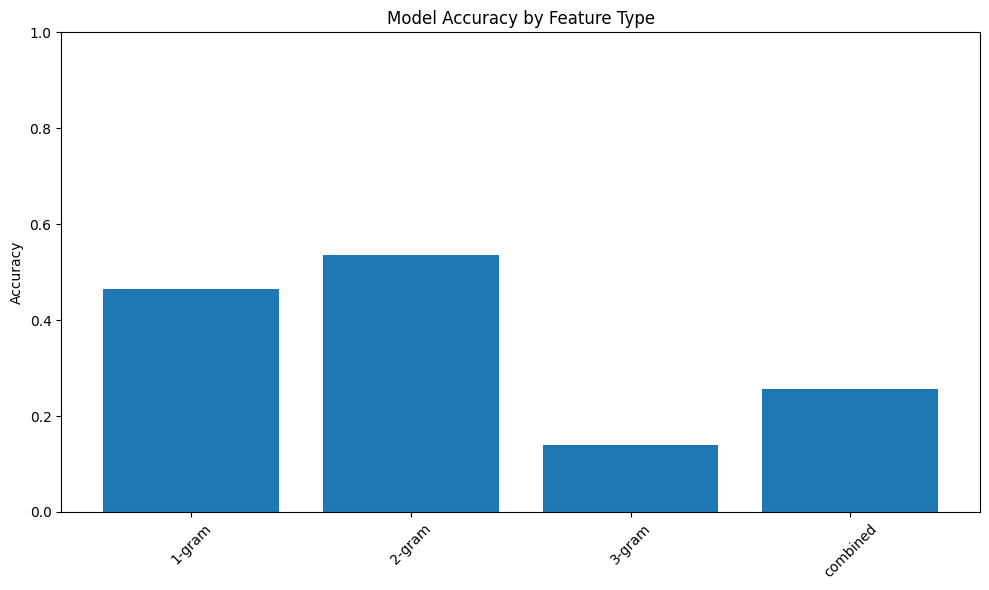

In [5]:
# Plot comparison of accuracies
plt.figure(figsize=(10, 6))
accuracies = [results[name]['accuracy'] for name in feature_sets.keys()]
plt.bar(feature_sets.keys(), accuracies)
plt.title('Model Accuracy by Feature Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Balancing Strategy

## Overview
This section addresses the class imbalance in our dataset using a two-step approach. The process ensures better representation of all APT groups in the training data.

## Methodology
1. **Random Oversampling**
   - First step to handle extremely underrepresented classes
   - Duplicates existing samples from minority classes
   - Creates a preliminary balanced dataset for further processing

2. **SMOTE (Synthetic Minority Over-sampling Technique)**
   - Applied after random oversampling
   - Creates synthetic samples by interpolating between existing samples
   - Adds variety to the training data while maintaining class characteristics

## Implementation
- Applied to all feature sets (1-gram, 2-gram, 3-gram, and combined)
- Maintains consistent random state (42) for reproducibility
- Preserves feature relationships while balancing classes

## Visualization
The three plots show:
1. Original class distribution
2. Distribution after random oversampling
3. Final distribution after SMOTE

This approach helps prevent model bias towards majority classes while maintaining the integrity of the feature space.


Original class distribution:
APT12_opcodes: 5
APT17_opcodes: 1
APT19_opcodes: 8
APT1_opcodes: 15
APT28: 21
APT29: 40
APT30_opcodes: 15
APT39: 1
APT41_opcodes: 1
AjaxSecurityTeam: 1
BlueMockingbird: 1
CobaltGroup: 2
DarkVishnya: 1
Dragonfly: 1
Dragonfly2.0: 1
Elderwood: 1
Evilnum: 1
FIN7: 2
Gallium: 5
Gamaredon: 1
Ke3chang: 5
MenuPass: 2
Moafee: 45
Patchwork: 1
Sandworm: 7
Sidewinder: 1
TEMP.VELES: 1
Turla: 24
admin38_opcodes: 2
bronze_butler_opcodes: 1
chimera_opcodes: 1
deep_panda_opcodes: 1

Class distribution after Random Oversampling:
APT12_opcodes: 45
APT17_opcodes: 45
APT19_opcodes: 45
APT1_opcodes: 45
APT28: 45
APT29: 45
APT30_opcodes: 45
APT39: 45
APT41_opcodes: 45
AjaxSecurityTeam: 45
BlueMockingbird: 45
CobaltGroup: 45
DarkVishnya: 45
Dragonfly: 45
Dragonfly2.0: 45
Elderwood: 45
Evilnum: 45
FIN7: 45
Gallium: 45
Gamaredon: 45
Ke3chang: 45
MenuPass: 45
Moafee: 45
Patchwork: 45
Sandworm: 45
Sidewinder: 45
TEMP.VELES: 45
Turla: 45
admin38_opcodes: 45
bronze_butler_opcodes: 45
chi

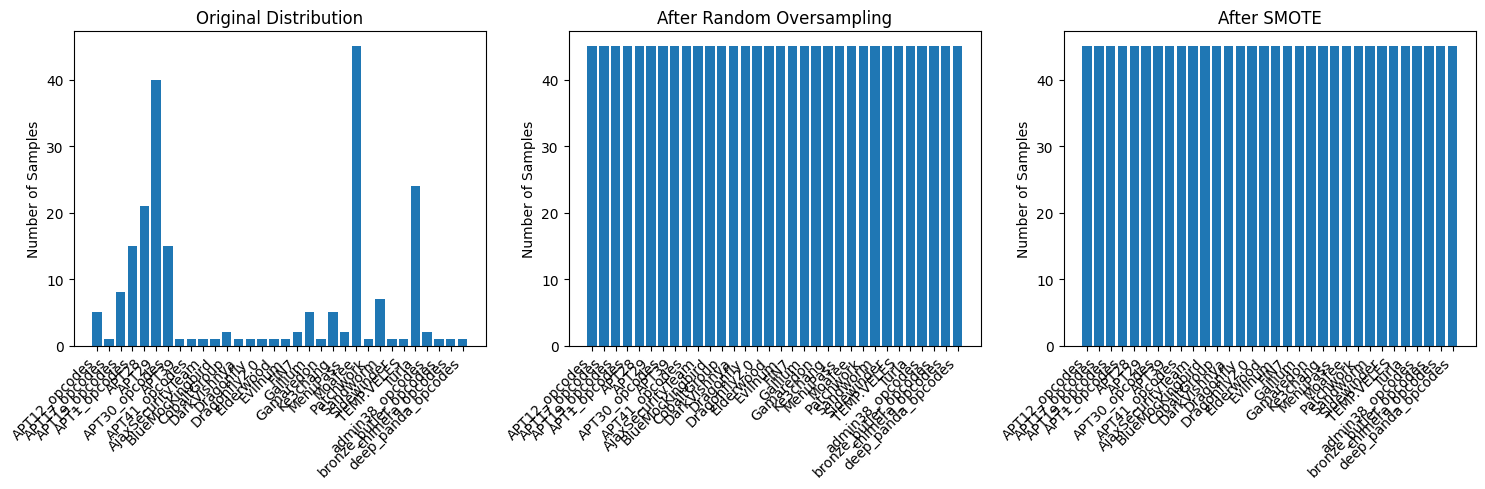

In [6]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Print original distribution
print("Original class distribution:")
for class_name, count in zip(le.classes_, np.bincount(y)):
    print(f"{class_name}: {count}")

# Step 1: Apply RandomOverSampler first to handle very small classes
ros = RandomOverSampler(random_state=42)
X_1gram_ros, y_1gram_ros = ros.fit_resample(X_1gram_scaled, y)
X_2gram_ros, y_2gram_ros = ros.fit_resample(X_2gram_scaled, y)
X_3gram_ros, y_3gram_ros = ros.fit_resample(X_3gram_scaled, y)
X_combined_ros, y_combined_ros = ros.fit_resample(X_combined, y)

print("\nClass distribution after Random Oversampling:")
for class_name, count in zip(le.classes_, np.bincount(y_1gram_ros)):
    print(f"{class_name}: {count}")

# Step 2: Apply SMOTE to create synthetic samples
smote = SMOTE(random_state=42)
X_1gram_balanced, y_1gram_balanced = smote.fit_resample(X_1gram_ros, y_1gram_ros)
X_2gram_balanced, y_2gram_balanced = smote.fit_resample(X_2gram_ros, y_2gram_ros)
X_3gram_balanced, y_3gram_balanced = smote.fit_resample(X_3gram_ros, y_3gram_ros)
X_combined_balanced, y_combined_balanced = smote.fit_resample(X_combined_ros, y_combined_ros)

print("\nFinal class distribution after SMOTE:")
for class_name, count in zip(le.classes_, np.bincount(y_1gram_balanced)):
    print(f"{class_name}: {count}")

# Split balanced datasets
X_train_1gram, X_test_1gram, y_train_1gram, y_test_1gram = train_test_split(
    X_1gram_balanced, y_1gram_balanced, test_size=0.2, random_state=42
)
X_train_2gram, X_test_2gram, y_train_2gram, y_test_2gram = train_test_split(
    X_2gram_balanced, y_2gram_balanced, test_size=0.2, random_state=42
)
X_train_3gram, X_test_3gram, y_train_3gram, y_test_3gram = train_test_split(
    X_3gram_balanced, y_3gram_balanced, test_size=0.2, random_state=42
)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined_balanced, y_combined_balanced, test_size=0.2, random_state=42
)

# Update feature_sets dictionary with balanced data
feature_sets = {
    '1-gram': (X_train_1gram, X_test_1gram, y_train_1gram, y_test_1gram),
    '2-gram': (X_train_2gram, X_test_2gram, y_train_2gram, y_test_2gram),
    '3-gram': (X_train_3gram, X_test_3gram, y_train_3gram, y_test_3gram),
    'combined': (X_train_combined, X_test_combined, y_train_combined, y_test_combined)
}

# Visualize class distribution at each stage
plt.figure(figsize=(15, 5))

# Original distribution
plt.subplot(1, 3, 1)
plt.bar(le.classes_, np.bincount(y))
plt.title('Original Distribution')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Samples')

# After Random Oversampling
plt.subplot(1, 3, 2)
plt.bar(le.classes_, np.bincount(y_1gram_ros))
plt.title('After Random Oversampling')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Samples')

# After SMOTE
plt.subplot(1, 3, 3)
plt.bar(le.classes_, np.bincount(y_1gram_balanced))
plt.title('After SMOTE')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()

# Convolutional Neural Network (CNN) Training and Evaluation with Balanced Data

## Define CNN Model
This section defines a function to create a CNN model for classification tasks. 
The model includes:
- Two Conv1D layers with ReLU activation and MaxPooling
- Dropout layers to reduce overfitting
- A Dense layer for fully connected processing
- A final Dense layer with softmax activation for multi-class classification
The model is compiled with:
- Adam optimizer with learning rate 1e-2 (as per McLaughlin et al.)
- Sparse categorical cross-entropy loss
- Accuracy as a performance metric

## Train and Evaluate Models
This section trains CNN models for each n-gram feature set (1-gram, 2-gram, 3-gram, combined).

### Steps:
1. **Reshape Data**: Convert feature sets into shapes compatible with Conv1D layers
2. **Create CNN Model**: Instantiate the CNN model using the defined function
3. **Train the Model**: Train the CNN on the respective feature set
   - Training includes:
     - 10 epochs (as per McLaughlin et al.)
     - Batch size of 32
     - 20% of training data reserved for validation
4. **Evaluate the Model**: 
   - Predict class probabilities and extract predicted class labels
   - Calculate the accuracy score
   - Generate a classification report with:
     - Unique class labels
     - Matching target names from the label encoder
5. **Store Results**:
   - Save accuracy, training history, true labels, and predicted labels for each feature set

### Visualizations:
1. **Confusion Matrices**: Show prediction distribution for each feature set
   - Values displayed as decimals for clarity
   - Custom formatting for improved readability
2. **Training History**: Plot accuracy curves for each model
   - Shows both training and validation accuracy
   - Helps identify overfitting/underfitting
3. **Comparative Analysis**: Bar plot comparing accuracies across feature types

### Outputs:
- Model training progress and validation results
- Accuracy and classification report for each feature set
- Visual comparisons of model performance


Training model with 1-gram features
Epoch 1/10


/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2072 - loss: 3.3446 - val_accuracy: 0.5974 - val_loss: 1.4706
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5784 - loss: 1.5218 - val_accuracy: 0.7273 - val_loss: 1.0291
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6604 - loss: 1.0500 - val_accuracy: 0.7619 - val_loss: 0.9595
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6803 - loss: 1.1061 - val_accuracy: 0.7576 - val_loss: 0.8372
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7104 - loss: 0.9752 - val_accuracy: 0.7922 - val_loss: 0.7308
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7076 - loss: 0.8581 - val_accuracy: 0.7359 - val_loss: 0.7066
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7247 - loss: 0.8749 - val_accuracy: 0.7706 - val_loss: 0.6855
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7567 - loss: 0.7512 - val_accuracy: 0.7446 - val_loss: 0.

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

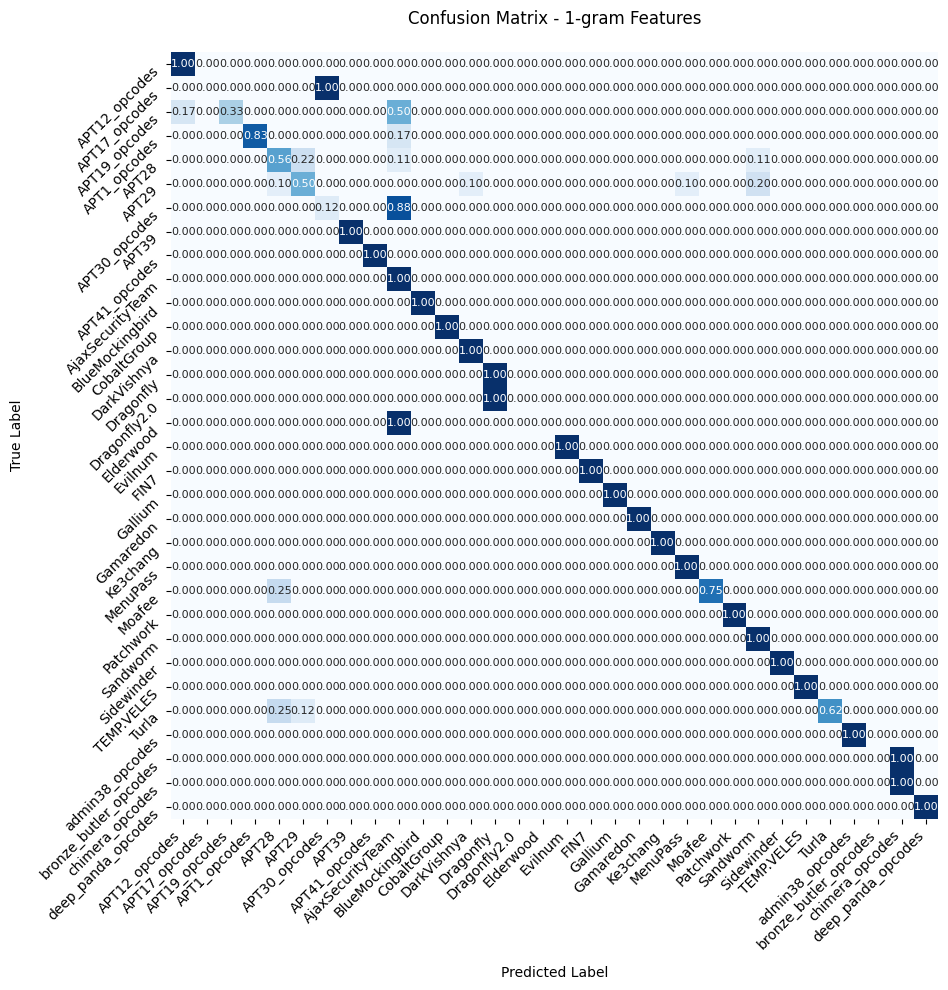


1-gram Results:
Accuracy: 0.7847

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       0.91      1.00      0.95        10
        APT17_opcodes       0.00      0.00      0.00        10
        APT19_opcodes       1.00      0.33      0.50         6
         APT1_opcodes       1.00      0.83      0.91        12
                APT28       0.56      0.56      0.56         9
                APT29       0.62      0.50      0.56        10
        APT30_opcodes       0.09      0.12      0.11         8
                APT39       1.00      1.00      1.00         6
        APT41_opcodes       1.00      1.00      1.00         8
     AjaxSecurityTeam       0.25      1.00      0.40         8
      BlueMockingbird       1.00      1.00      1.00        13
          CobaltGroup       1.00      1.00      1.00        13
          DarkVishnya       0.86      1.00      0.92         6
            Dragonfly       0.63      1.00      0.77       

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.2238 - loss: 10.0631 - val_accuracy: 0.7056 - val_loss: 1.1609
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6864 - loss: 1.2887 - val_accuracy: 0.8095 - val_loss: 0.6638
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8224 - loss: 0.7180 - val_accuracy: 0.8052 - val_loss: 0.5351
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8038 - loss: 0.6871 - val_accuracy: 0.8095 - val_loss: 0.4871
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8235 - loss: 0.5041 - val_accuracy: 0.8268 - val_loss: 0.4324
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8511 - loss: 0.3834 - val_accuracy: 0.8398 - val_loss: 0.4260
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8406 - loss: 0.3522 - val_accuracy: 0.8225 - val_loss: 0.4257
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8661 - loss: 0.3769 - val_accuracy: 0.8312 - val_loss: 0

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

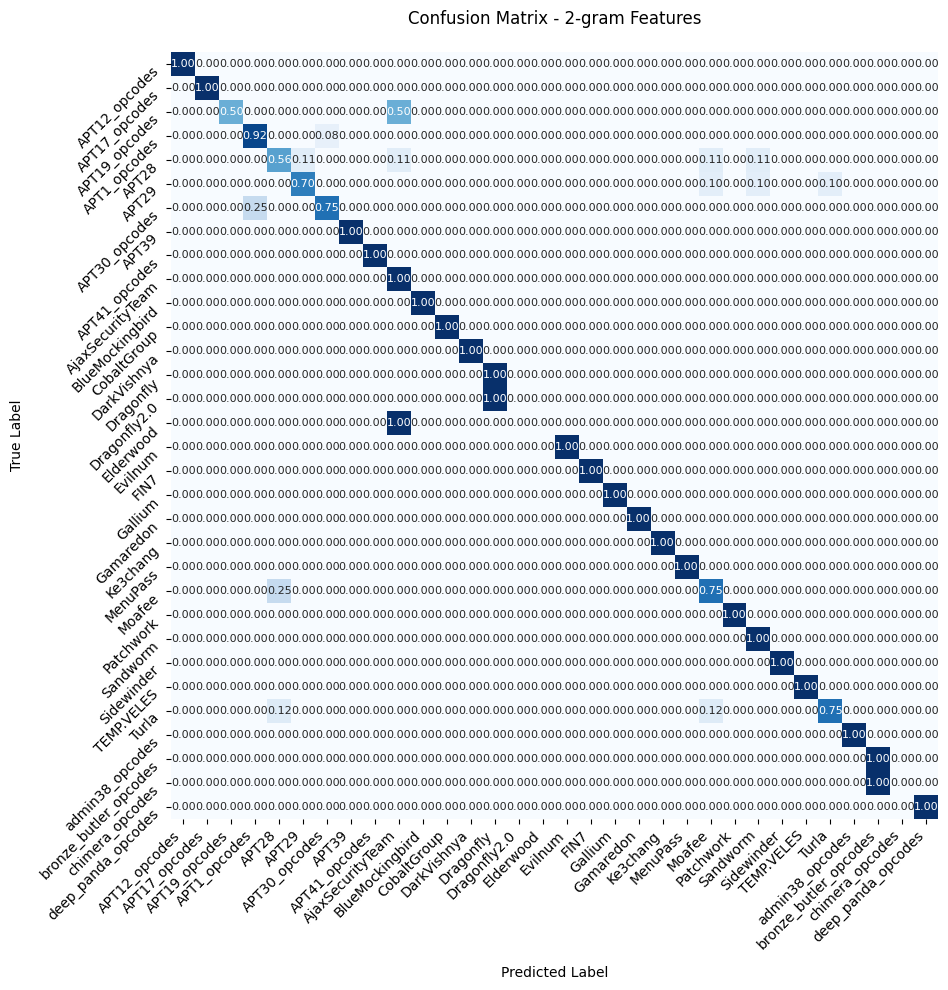


2-gram Results:
Accuracy: 0.8542

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00        10
        APT17_opcodes       1.00      1.00      1.00        10
        APT19_opcodes       1.00      0.50      0.67         6
         APT1_opcodes       0.85      0.92      0.88        12
                APT28       0.71      0.56      0.62         9
                APT29       0.88      0.70      0.78        10
        APT30_opcodes       0.86      0.75      0.80         8
                APT39       1.00      1.00      1.00         6
        APT41_opcodes       1.00      1.00      1.00         8
     AjaxSecurityTeam       0.35      1.00      0.52         8
      BlueMockingbird       1.00      1.00      1.00        13
          CobaltGroup       1.00      1.00      1.00        13
          DarkVishnya       1.00      1.00      1.00         6
            Dragonfly       0.63      1.00      0.77       

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.1135 - loss: 24.5181 - val_accuracy: 0.0173 - val_loss: 3.4729
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 424ms/step - accuracy: 0.0773 - loss: 3.3780 - val_accuracy: 0.6061 - val_loss: 1.5587
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.6456 - loss: 1.4432 - val_accuracy: 0.8442 - val_loss: 0.7364
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - accuracy: 0.8092 - loss: 0.7950 - val_accuracy: 0.8528 - val_loss: 0.4612
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step - accuracy: 0.8171 - loss: 0.6179 - val_accuracy: 0.8701 - val_loss: 0.3371
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 423ms/step - accuracy: 0.8692 - loss: 0.3386 - val_accuracy: 0.8701 - val_loss: 0.3173
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.8869 - loss: 0.3198 - val_accuracy: 0.8961 - val_loss: 0.2571
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 408ms/step - accuracy: 0.8992 - loss: 0.2939 - val_acc

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

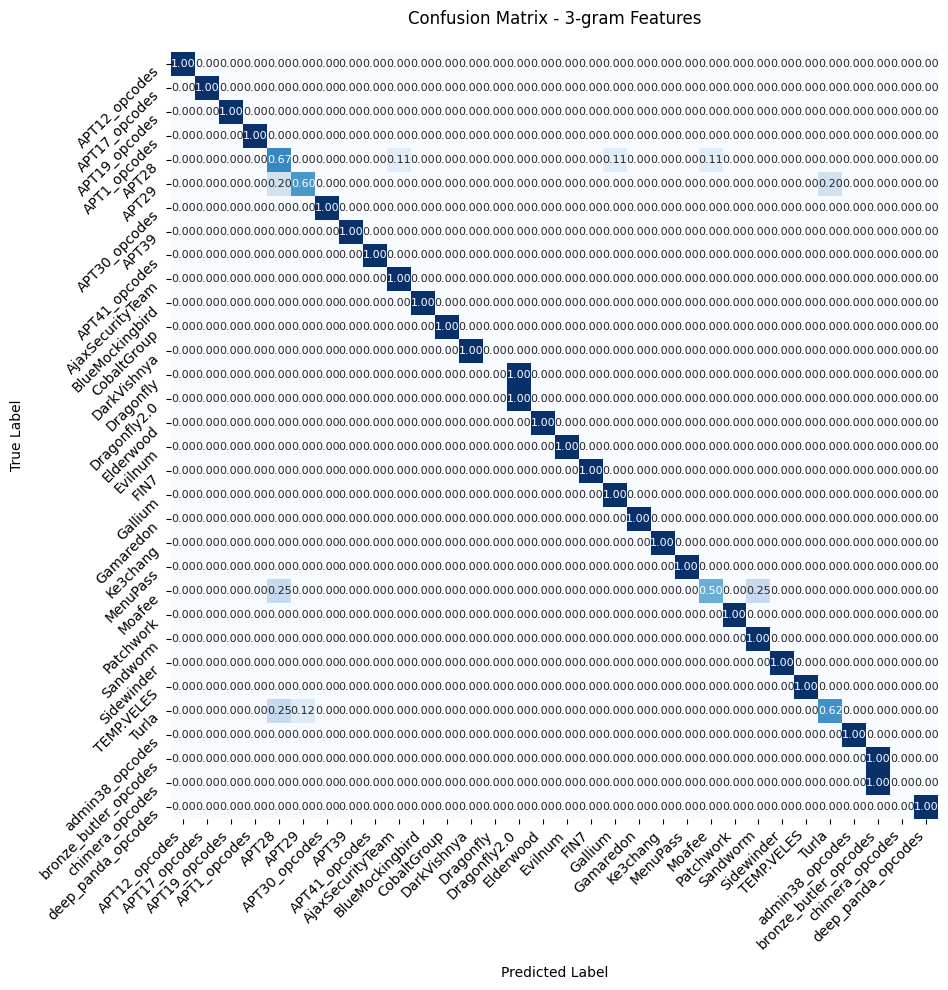


3-gram Results:
Accuracy: 0.8889

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00        10
        APT17_opcodes       1.00      1.00      1.00        10
        APT19_opcodes       1.00      1.00      1.00         6
         APT1_opcodes       1.00      1.00      1.00        12
                APT28       0.55      0.67      0.60         9
                APT29       0.86      0.60      0.71        10
        APT30_opcodes       1.00      1.00      1.00         8
                APT39       1.00      1.00      1.00         6
        APT41_opcodes       1.00      1.00      1.00         8
     AjaxSecurityTeam       0.89      1.00      0.94         8
      BlueMockingbird       1.00      1.00      1.00        13
          CobaltGroup       1.00      1.00      1.00        13
          DarkVishnya       1.00      1.00      1.00         6
            Dragonfly       0.00      0.00      0.00       

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 529ms/step - accuracy: 0.1421 - loss: 17.9240 - val_accuracy: 0.6320 - val_loss: 1.9523
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 520ms/step - accuracy: 0.5919 - loss: 1.6906 - val_accuracy: 0.8485 - val_loss: 0.6671
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 594ms/step - accuracy: 0.8267 - loss: 0.6978 - val_accuracy: 0.8745 - val_loss: 0.4195
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 735ms/step - accuracy: 0.8712 - loss: 0.4145 - val_accuracy: 0.8831 - val_loss: 0.3362
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 600ms/step - accuracy: 0.8843 - loss: 0.3612 - val_accuracy: 0.8788 - val_loss: 0.2955
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 555ms/step - accuracy: 0.8769 - loss: 0.3089 - val_accuracy: 0.8745 - val_loss: 0.2900
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 576ms/step - accuracy: 0.8988 - loss: 0.2654 - val_accuracy: 0.8658 - val_loss: 0.2799
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step - accuracy: 0.8792 - loss: 0.2896 - val_acc

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

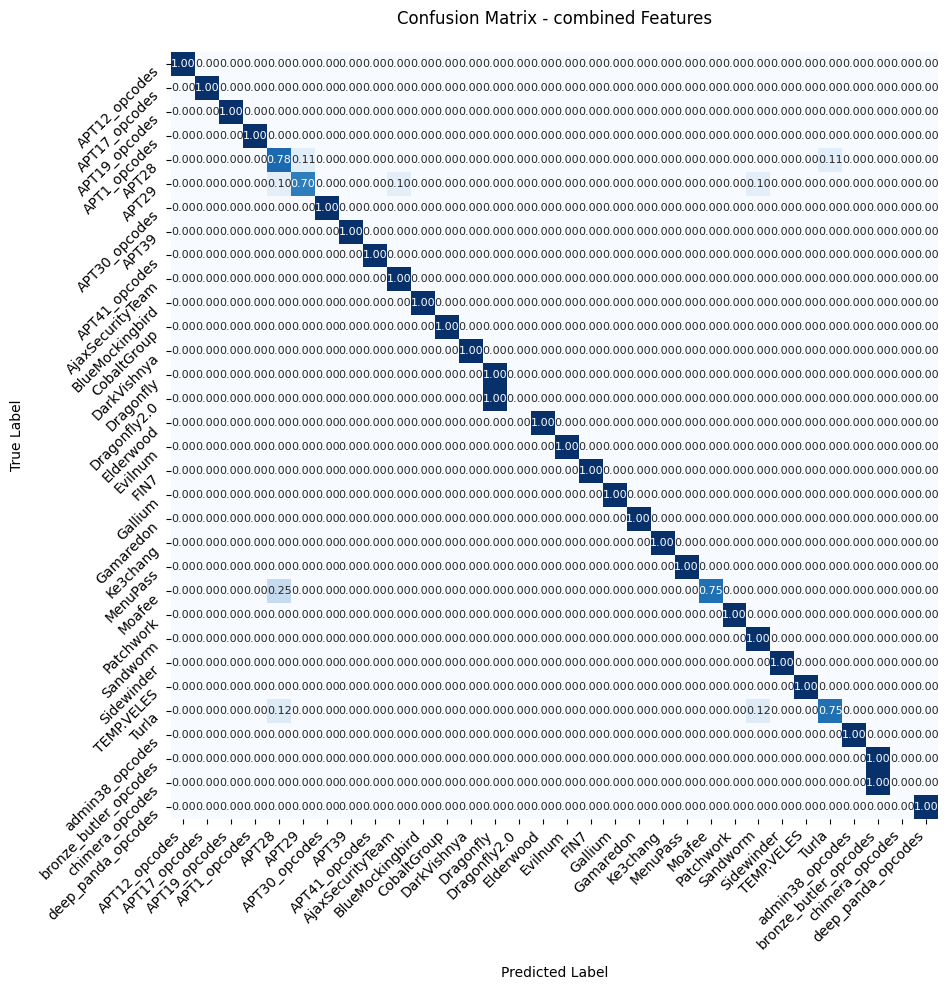


combined Results:
Accuracy: 0.9201

Classification Report:
                       precision    recall  f1-score   support

        APT12_opcodes       1.00      1.00      1.00        10
        APT17_opcodes       1.00      1.00      1.00        10
        APT19_opcodes       1.00      1.00      1.00         6
         APT1_opcodes       1.00      1.00      1.00        12
                APT28       0.70      0.78      0.74         9
                APT29       0.88      0.70      0.78        10
        APT30_opcodes       1.00      1.00      1.00         8
                APT39       1.00      1.00      1.00         6
        APT41_opcodes       1.00      1.00      1.00         8
     AjaxSecurityTeam       0.89      1.00      0.94         8
      BlueMockingbird       1.00      1.00      1.00        13
          CobaltGroup       1.00      1.00      1.00        13
          DarkVishnya       1.00      1.00      1.00         6
            Dragonfly       0.63      1.00      0.77     

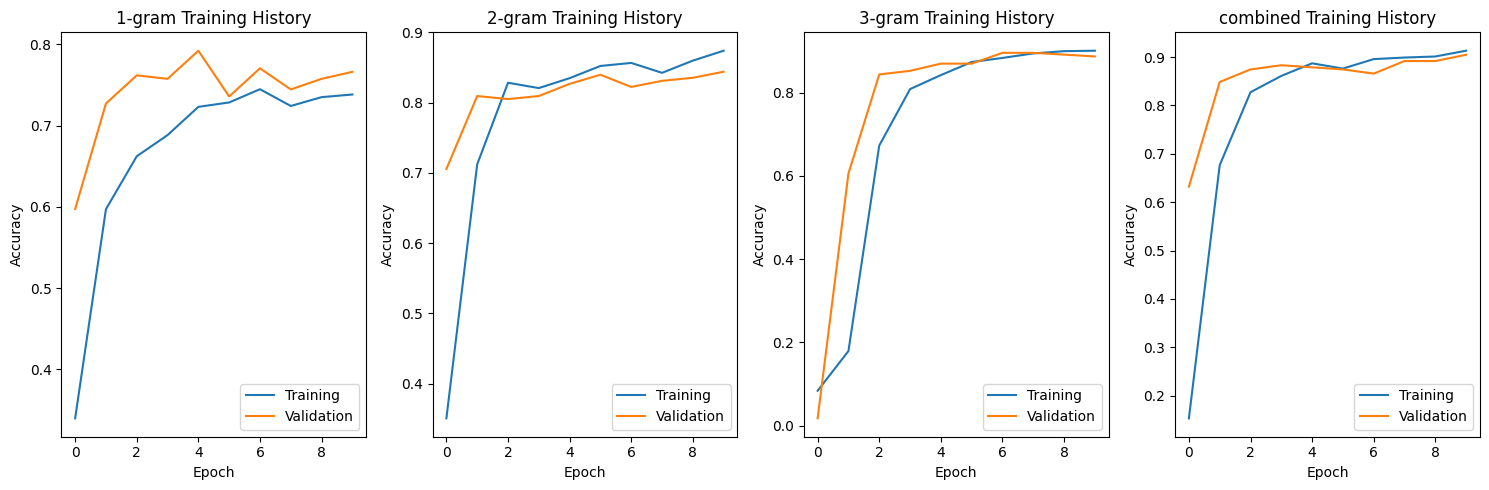

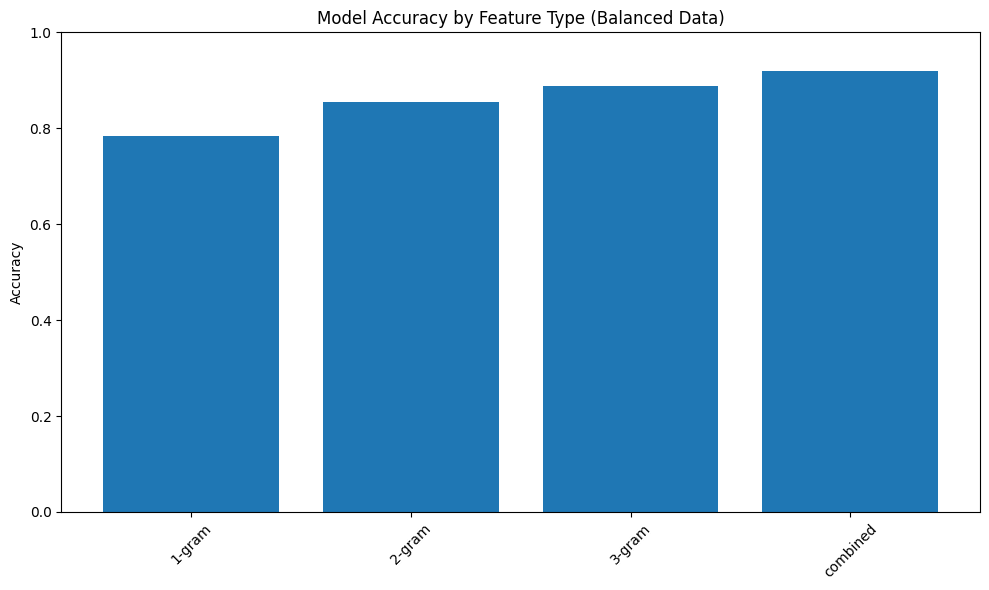


Final Results Summary (Balanced Data):

1-gram Features:
Accuracy: 0.7847

2-gram Features:
Accuracy: 0.8542

3-gram Features:
Accuracy: 0.8889

combined Features:
Accuracy: 0.9201


In [7]:
results = {}
for name, (X_train, X_test, y_train, y_test) in feature_sets.items():
    print(f"\nTraining model with {name} features")
    
    # Reshape data for CNN
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Create and train model
    model = create_cnn_model(X_train.shape[1], len(np.unique(y)))
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    
    # Get the actual classes present in the test set
    unique_classes = np.unique(y_test)
    class_names = [le.classes_[i] for i in unique_classes]
    
    # Generate classification report with matching labels
    report = classification_report(
        y_test, 
        y_pred_classes,
        labels=unique_classes,
        target_names=class_names
    )
    
        # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    # Calculate percentages as decimals
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix with improved readability
    plt.figure(figsize=(15, 10))  # Increased figure size
    sns.heatmap(
        cm_percentage, 
        annot=True, 
        fmt='.2f',  # Format as decimal with 2 decimal places
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        square=True,  # Make cells square
        cbar=False,   # Remove color bar for cleaner look
        annot_kws={'size': 8}  # Smaller font size for numbers
    )
    plt.title(f'Confusion Matrix - {name} Features', pad=20)
    plt.ylabel('True Label', labelpad=10)
    plt.xlabel('Predicted Label', labelpad=10)
    
    # Rotate labels and adjust their position
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, va='top')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    results[name] = {
        'accuracy': accuracy,
        'history': history.history,
        'y_true': y_test,
        'y_pred': y_pred_classes,
        'confusion_matrix_percentage': cm_percentage
    }

# Plot training history for each model
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 4, i)
    plt.plot(result['history']['accuracy'], label='Training')
    plt.plot(result['history']['val_accuracy'], label='Validation')
    plt.title(f'{name} Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot comparison of accuracies
plt.figure(figsize=(10, 6))
accuracies = [results[name]['accuracy'] for name in feature_sets.keys()]
plt.bar(feature_sets.keys(), accuracies)
plt.title('Model Accuracy by Feature Type (Balanced Data)')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final comparison
print("\nFinal Results Summary (Balanced Data):")
for name, result in results.items():
    print(f"\n{name} Features:")
    print(f"Accuracy: {result['accuracy']:.4f}")

# Comprehensive Performance Evaluation

## Performance Metrics Analysis
This section provides a detailed evaluation of model performance using multiple metrics for each feature type (1-gram, 2-gram, 3-gram, and combined).

### Metrics Calculated:
1. **Accuracy**: Overall correct predictions ratio
2. **Precision**: Measure of prediction exactness
3. **Recall**: Measure of prediction completeness
4. **F1-Score**: Harmonic mean of precision and recall

### Averaging Methods:
1. **Macro-averaging**:
   - Treats all classes equally
   - Calculates metrics for each class independently
   - Takes unweighted mean across classes
   - Better for imbalanced datasets when minority class performance is important

2. **Weighted-averaging**:
   - Accounts for class imbalance
   - Weights metrics by class frequency
   - More representative of overall system performance
   - Better for understanding performance on majority classes

## Visualization
The comparative bar plot provides:
- Side-by-side comparison of all metrics across feature types
- Clear visualization of relative performance
- Easy identification of best-performing feature sets
- Insights into trade-offs between different metrics

### Plot Features:
- X-axis: Different evaluation metrics
- Y-axis: Score (0 to 1)
- Color-coded bars for different feature types
- Legend for easy identification
- Consistent scale for fair comparison

This comprehensive evaluation helps understand the model's performance across different aspects and identify the most effective feature representation for APT classification.


Final Results Summary (Balanced Data):

1-gram Features:
Accuracy: 0.7847

Macro-averaged metrics:
Precision: 0.7507
Recall: 0.7726
F1-score: 0.7420

Weighted-averaged metrics:
Precision: 0.7560
Recall: 0.7847
F1-score: 0.7536

2-gram Features:
Accuracy: 0.8542

Macro-averaged metrics:
Precision: 0.8103
Recall: 0.8413
F1-score: 0.8124

Weighted-averaged metrics:
Precision: 0.8223
Recall: 0.8542
F1-score: 0.8265

3-gram Features:
Accuracy: 0.8889

Macro-averaged metrics:
Precision: 0.8548
Recall: 0.8872
F1-score: 0.8622

Weighted-averaged metrics:
Precision: 0.8602
Recall: 0.8889
F1-score: 0.8672

combined Features:
Accuracy: 0.9201

Macro-averaged metrics:
Precision: 0.8829
Recall: 0.9056
F1-score: 0.8888

Weighted-averaged metrics:
Precision: 0.8924
Recall: 0.9201
F1-score: 0.9010


/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

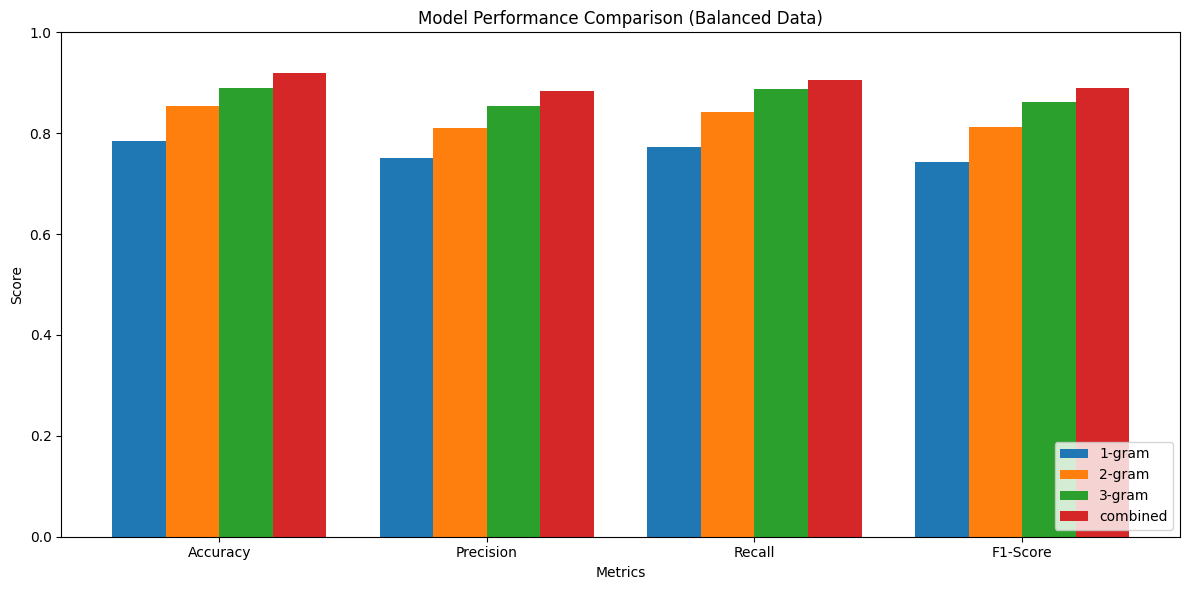

In [8]:
# Calculate and print final comprehensive results
print("\nFinal Results Summary (Balanced Data):")
for name, result in results.items():
    print(f"\n{name} Features:")
    
    # Calculate precision, recall, and f1 (macro averaged)
    precision, recall, f1, _ = precision_recall_fscore_support(
        result['y_true'], 
        result['y_pred'], 
        average='macro'
    )
    
    # Calculate weighted versions too
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        result['y_true'], 
        result['y_pred'], 
        average='weighted'
    )
    
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("\nMacro-averaged metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nWeighted-averaged metrics:")
    print(f"Precision: {precision_weighted:.4f}")
    print(f"Recall: {recall_weighted:.4f}")
    print(f"F1-score: {f1_weighted:.4f}")

# Create a comparison bar plot for all metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
feature_types = list(feature_sets.keys())

# Collect all metrics
all_metrics = {name: [] for name in feature_types}
for name, result in results.items():
    precision, recall, f1, _ = precision_recall_fscore_support(
        result['y_true'], 
        result['y_pred'], 
        average='macro'
    )
    all_metrics[name] = [
        result['accuracy'],
        precision,
        recall,
        f1
    ]

# Plot comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics_names))
width = 0.2
multiplier = 0

for feature_type, metrics in all_metrics.items():
    offset = width * multiplier
    plt.bar(x + offset, metrics, width, label=feature_type)
    multiplier += 1

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Balanced Data)')
plt.xticks(x + width * (len(feature_types) - 1) / 2, metrics_names)
plt.legend(loc='lower right')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Raw Opcode Sequence Analysis (McLaughlin et al. Approach)

## Overview
This section implements the direct sequence approach from McLaughlin et al.'s paper, processing raw opcode sequences rather than using n-gram frequency features. Despite following the paper's methodology, our results show that n-gram frequency features performed better, particularly after data balancing.

## Data Processing Pipeline
1. **Vocabulary Creation**:
   - Builds a dictionary of unique opcodes from the dataset
   - Maps each opcode to a unique integer
   - Creates an embedding-ready format

2. **Sequence Preprocessing**:
   - Converts variable-length opcode sequences to fixed length (2000)
   - Handles padding for shorter sequences
   - Truncates longer sequences to maintain consistency

3. **Data Balancing**:
   - Applies the same two-step balancing strategy:
     - Random oversampling for extremely rare classes
     - SMOTE for creating synthetic samples
   - Maintains consistency with n-gram approach for fair comparison

## Modified CNN Architecture
- **Embedding Layer**: Converts integer-encoded opcodes to dense vectors
- **Convolutional Layers**: Same structure as n-gram approach
- **Training Parameters**:
  - Learning rate: 1e-2 (as per McLaughlin et al.)
  - Epochs: 10
  - Batch size: 16

## Performance Analysis
While this approach maintains sequence order information, our results show:
- Lower accuracy compared to n-gram frequency features
- More volatile training curves
- Less consistent performance across APT groups
- Higher sensitivity to class imbalance

### Possible Explanations:
1. Loss of global frequency information that n-grams capture effectively
2. Difficulty in learning from very long sequences
3. Challenge in handling variable-length inputs despite padding
4. Dataset characteristics might favor frequency-based features

This comparison suggests that for our specific APT classification task, the n-gram frequency approach might be more suitable, especially when combined with proper data balancing techniques.

Vocabulary size: 520
Training CNN with raw opcode sequences
Epoch 1/10


/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.0702 - loss: 3.7969 - val_accuracy: 0.0628 - val_loss: 4.9353
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4381 - loss: 1.8917 - val_accuracy: 0.0628 - val_loss: 7.3074
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5855 - loss: 1.2049 - val_accuracy: 0.0628 - val_loss: 4.5702
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6622 - loss: 0.9789 - val_accuracy: 0.0628 - val_loss: 3.7232
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7341 - loss: 0.8553 - val_accuracy: 0.1623 - val_loss: 3.4050
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7758 - loss: 0.6615 - val_accuracy: 0.3403 - val_loss: 2.3031
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8316 - loss: 0.5584 - val_accuracy: 0.6126 - val_loss: 1.5749
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7820 - loss: 0.6214 - val_accuracy: 0.6387 - val_loss: 1.

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

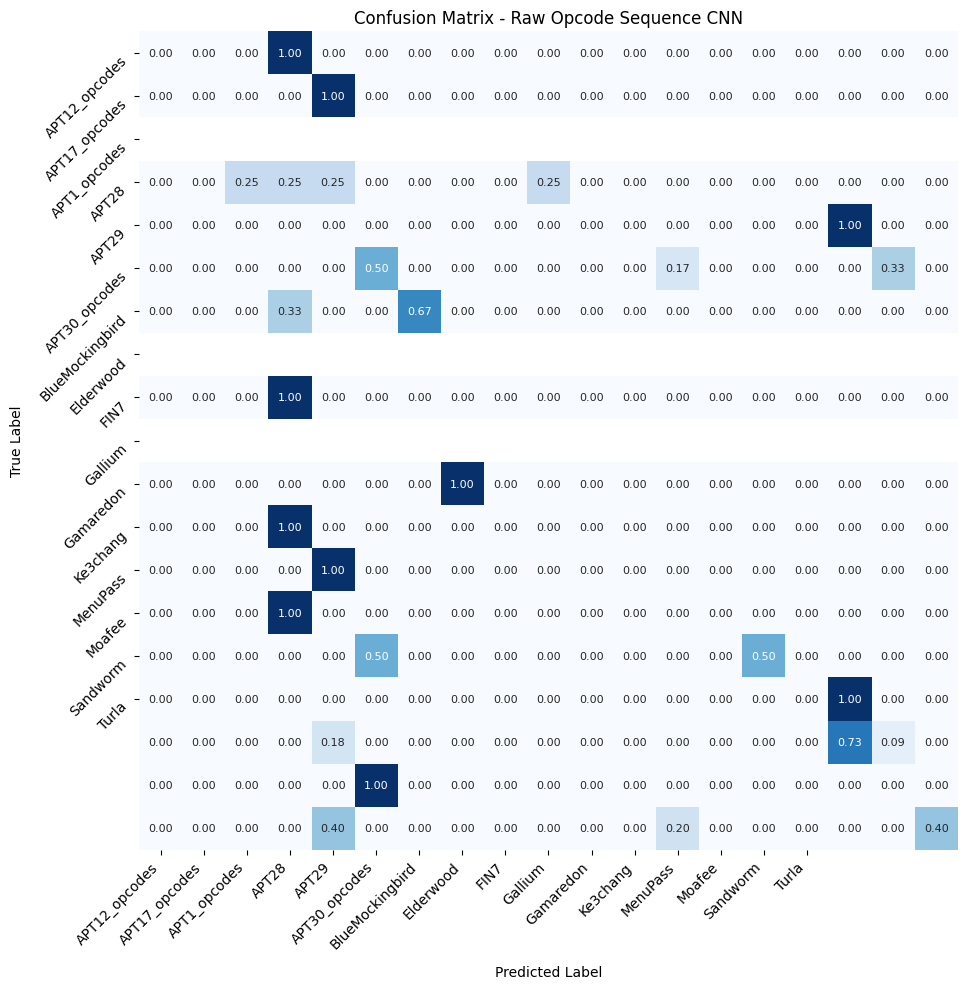


Raw Opcode Sequence Results:
Accuracy: 0.3953

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.17      0.25      0.20         4
          APT28       0.00      0.00      0.00         3
          APT29       0.60      0.50      0.55         6
  APT30_opcodes       1.00      0.67      0.80         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       1.00      0.50      0.67         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.67      0.73      0.70        11
       Sandworm       0.00      0.00      0.00         1
          Turla 

In [10]:
# First, create a vocabulary of all unique opcodes
def create_opcode_vocabulary(df):
    # Get all unique opcodes
    vocab = set()
    for sequence in df['Opcodes']:
        opcodes = [op.strip() for op in sequence.split(',')]
        vocab.update(opcodes)
    
    # Create a mapping dictionary
    vocab_dict = {op: idx for idx, op in enumerate(sorted(vocab))}
    return vocab_dict, len(vocab)

def preprocess_opcodes(opcode_sequences, vocab_dict, max_sequence_length=2000):
    """Convert opcode sequences to integer sequences of fixed length"""
    processed_sequences = []
    
    for sequence in opcode_sequences:
        # Convert string to list of opcodes
        opcodes = [op.strip() for op in sequence.split(',')]
        
        # Convert to integers using vocabulary
        int_sequence = [vocab_dict[op] for op in opcodes]
        
        # Pad or truncate to fixed length
        if len(int_sequence) > max_sequence_length:
            int_sequence = int_sequence[:max_sequence_length]
        else:
            int_sequence = int_sequence + [0] * (max_sequence_length - len(int_sequence))
            
        processed_sequences.append(int_sequence)
    
    return np.array(processed_sequences)

# Create vocabulary from all sequences
vocab_dict, vocab_size = create_opcode_vocabulary(df)
print(f"Vocabulary size: {vocab_size}")

# Preprocess sequences
X = preprocess_opcodes(df['Opcodes'], vocab_dict)
y = le.fit_transform(df['APT'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply balancing as before
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_ros, y_train_ros)

# Modify CNN model for sequence input
def create_sequence_cnn_model(sequence_length, vocab_size, num_classes):
    model = Sequential([
        # Embedding layer to convert integers to dense vectors
        tf.keras.layers.Embedding(vocab_size + 1, 32, input_length=sequence_length),
        
        # CNN layers
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Use learning rate from McLaughlin et al.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train model
print("Training CNN with raw opcode sequences")
model = create_sequence_cnn_model(
    sequence_length=2000,
    vocab_size=vocab_size,
    num_classes=len(np.unique(y))
)

history = model.fit(
    X_train_balanced, y_train_balanced,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
unique_classes = np.unique(y_test)
class_names = [le.classes_[i] for i in unique_classes]

# Generate classification report
report = classification_report(
    y_test, 
    y_pred_classes,
    labels=unique_classes,
    target_names=class_names
)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(
    cm_percentage, 
    annot=True, 
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    cbar=False,
    annot_kws={'size': 8}
)
plt.title('Confusion Matrix - Raw Opcode Sequence CNN')
plt.ylabel('True Label', labelpad=10)
plt.xlabel('Predicted Label', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, va='top')
plt.tight_layout()
plt.show()

# Print results
print("\nRaw Opcode Sequence Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)